# Plots for Burgers' Equation

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from BurgerData import BurgerData
import torch

import sys
sys.path.append('../../utils')
from upinn import UPINN, NullWork
from architectures import FNN

In [27]:
data = BurgerData()

In [28]:
u = data.data_points_full[1].reshape(*data.original_shape).numpy()
x = data.x.squeeze()
t = data.t.squeeze()

In [29]:
u_x = np.gradient(u, x, axis=0)

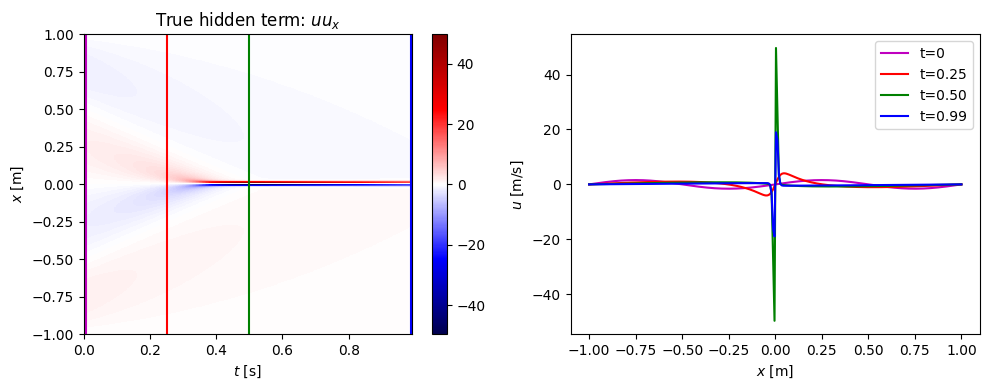

In [30]:
plt.subplots(1, 2, figsize=(10, 4))

colors = ['b', 'g', 'b']

plt.subplot(1, 2, 1)
plt.imshow(u*u_x, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'True hidden term: $uu_x$')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$x$ [m]')
plt.plot([0.005, 0.005], [-1, 1], label='t=0', color='m')
plt.plot([0.25, 0.25], [-1, 1], 'r', label='t=0.25')
plt.plot([0.5, 0.5], [-1, 1], 'g', label='t=0.5')
plt.plot([0.9875, 0.9875], [-1, 1], 'b', label='t=1')

plt.subplot(1, 2, 2)
plt.plot(x, u[:, 0]*u_x[:, 0], label='t=0', color='m')
plt.plot(x, u[:, 25]*u_x[:, 25], label='t=0.25', color='r')
plt.plot(x, u[:, 50]*u_x[:, 50], label='t=0.50', color='g')
plt.plot(x, u[:, -1]*u_x[:, -1], label='t=0.99', color='b')
plt.legend()
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$u$ [m/s]')



plt.tight_layout()
plt.savefig('gfx/burger_true_res.pdf', format='pdf', bbox_inches='tight')

plt.show()




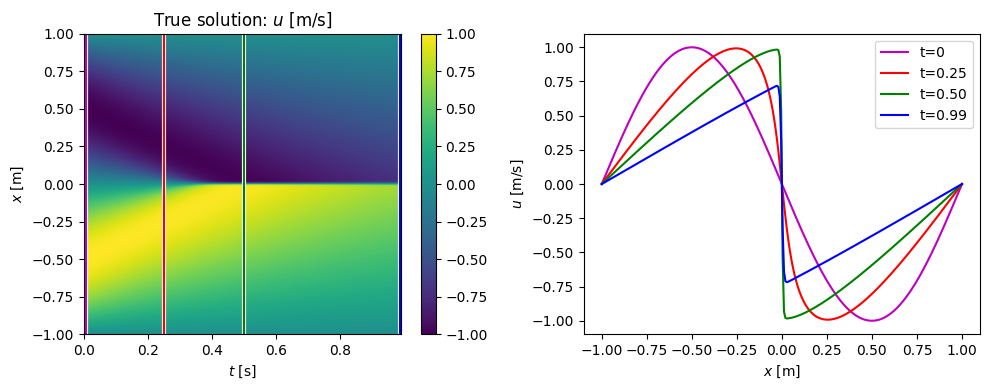

In [31]:
plt.subplots(1, 2, figsize=(10, 4))

colors = ['b', 'g', 'b']

plt.subplot(1, 2, 1)
plt.imshow(u, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.title(r'True solution: $u$ [m/s]')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$x$ [m]')
plt.plot([0.0075, 0.0075], [-1, 1], linewidth=3, color='w')
plt.plot([0.25, 0.25], [-1, 1], linewidth=3, color='w')
plt.plot([0.5, 0.5], [-1, 1], linewidth=3, color='w')
plt.plot([0.9875, 0.9875], [-1, 1], linewidth=3, color='w')
plt.plot([0.0075, 0.0075], [-1, 1], label='t=0', color='m')
plt.plot([0.25, 0.25], [-1, 1], 'r', label='t=0.25')
plt.plot([0.5, 0.5], [-1, 1], 'g', label='t=0.5')
plt.plot([0.9875, 0.9875], [-1, 1], 'b', label='t=1')

plt.subplot(1, 2, 2)
plt.plot(x, u[:, 0], label='t=0', color='m')
plt.plot(x, u[:, 25], label='t=0.25', color='r')
plt.plot(x, u[:, 50], label='t=0.50', color='g')
plt.plot(x, u[:, -1], label='t=0.99', color='b')
plt.legend()
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$u$ [m/s]')



plt.tight_layout()
plt.savefig('gfx/burger_true.pdf', format='pdf', bbox_inches='tight')

plt.show()


In [32]:
class UPINN(UPINN):
    
    # No inductive bias on F
    def F_input(self, X, U):
        if not self.inductive_bias:
            return torch.cat((X, U), dim=-1)
        else:
            dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
            u_t = dudxt[:,0:1]
            u_x = dudxt[:,1:2]
            return torch.cat((U, u_t, u_x), dim=-1)

In [33]:
name = 'burger_upinn_clean_RAD'
save = True
# data_slices = [0.25, 0.5, 0.985]
data_slices = [0.5]

In [34]:
def get_predictions(model_name, num_hidden=8, dim_hidden=20, bias=True):

    hidden = [dim_hidden] * num_hidden

    u = FNN(
        dims=[2, *hidden, 1],
        hidden_act=torch.nn.Tanh(),
        output_act=torch.nn.Identity(),
    )
    F = FNN(
        dims=[3, *hidden, 1],
        hidden_act=torch.nn.Tanh(),
        output_act=torch.nn.Identity(),
    )

    model = UPINN(u, N=NullWork(), F=F)
    model.inductive_bias = bias
    model.load(model_name, 'models')

    data.data_points_full[0].requires_grad_(True)
    u = model.u(data.data_points_full[0])
    u_x = torch.autograd.grad(u, data.data_points_full[0], torch.ones_like(u), create_graph=True)[0][:,1:2]
    
    U_pred = u.detach().numpy().reshape(*data.original_shape)
    U_true = data.data_points_full[1].reshape(*data.original_shape).numpy()
    x = data.x.squeeze()
    t = data.t.squeeze()
    
    F_exp = (u*u_x).detach().numpy().reshape(*data.original_shape)

    F_pred = model.F(model.F_input(data.data_points_full[0].requires_grad_(True), model.u(data.data_points_full[0]))).detach().numpy().reshape(*data.original_shape)
    F_true = U_true * np.gradient(U_true, x, axis=0)

    return U_pred, U_true, F_pred, F_true, F_exp

In [35]:
def plot_burger_model(name, data_slices=[], save=None, include_hidden=True, bias=True):
    U_pred, U_true, F_pred, F_true, F_exp = get_predictions(name, bias=bias)
    
    if include_hidden:
        dim = 2
    else:
        dim = 1

    plt.subplots(dim, 2, figsize=(10, 3*dim))

    # Predicted solution
    v = abs(U_true).max()
    plt.subplot(dim, 2, 1)
    plt.imshow(U_pred, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    for slice in data_slices:
        plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
    plt.title(r'Predicted solution: $\hat{u}$ [m/s]')
    plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')

    # Absolute error in solution prediction
    plt.subplot(dim, 2, 2)
    plt.imshow(abs(U_pred-U_true), aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='jet', vmin=0)
    plt.colorbar()
    for slice in data_slices:
        plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
    plt.title(r'Absolute error: $|u-\hat{u}|$')
    plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')

    if include_hidden:
        # Predicted hidden term
        v = abs(F_true).max()
        plt.subplot(dim, 2, 3)
        plt.imshow(F_pred, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='seismic', vmin=-v, vmax=v)
        plt.colorbar()
        for slice in data_slices:
            plt.plot([slice, slice], [-1, 1], linewidth=1, color='black', linestyle='--')
        plt.title(r'Predicted hidden term: $\hat{F}$')
        plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')

        # Absolute error in hidden term prediction
        plt.subplot(dim, 2, 4)
        plt.imshow(abs(F_pred-F_exp), aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='jet', vmin=0)
        plt.colorbar()
        for slice in data_slices:
            plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
        plt.title(r'Absolute error: $|\hat{F}_{exp}-\hat{F}|$')
        plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')
    
    plt.tight_layout()

    if save:
        save_str = 'gfx/burger_upinn_'+save+'.pdf'
        print('Saving as', save_str)
        plt.savefig(save_str, format='pdf', bbox_inches='tight')

    plt.show()

[Info]: Initializing UPINN model
Saving as gfx/burger_upinn_baseline_clean_bias.pdf


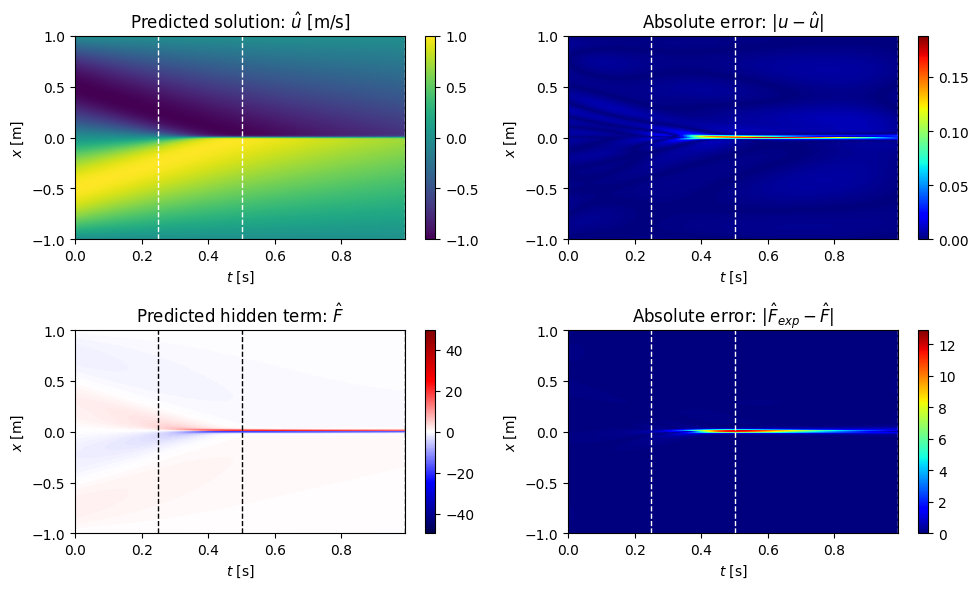

In [69]:
# name = 'tanh_sparse_noisy_burger_upinn'
# name = 'burger_baseline_sparse_noise01-sa005'
# name = 'burger_RAD_sparse_noise01-sa005-noboundary-nobias'
# name = 'burger_baseline_sparse_noise01-lbfgs'
# name = 'burger_upinn_clean_RAD-nobias'
# name = 'burger_upinn_clean_RAD-bias'
# name = 'burger_baseline_clean-bias'
# name = 'tanh_nobias_clean_sparse'
# name = 'tanh_sparse_burger_upinn'
name = 'tanh_sobol_clean_burger_upinn'
# name = 'burger_baseline_clean'
# name = 'tanh_burger_upinn'
# plot_burger_model(name, data_slices, include_hidden=True, save='baseline_sparse_clean_bias')
# plot_burger_model(name, data_slices, include_hidden=True, bias=True)
plot_burger_model(name, include_hidden=True, bias=True, data_slices=[0.25, 0.5, 0.99], save='baseline_clean_bias')

[Info]: Initializing UPINN model
Saving as gfx/burger_upinn_burger_bias_trained_on_residual.pdf


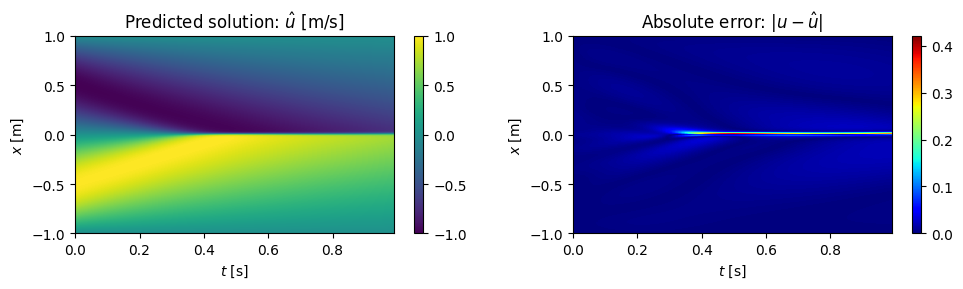

In [72]:
# name = 'burger_baseline_clean-nobias2'
# name = 'burger_pinn_with_residual_network_bias'
# name = 'burger_baseline_clean'
# name = 'tanh_burger_upinn'
# name = 'burger_upinn_clean-bias'
# name = 'burger_upinn_clean_RAD-bias'
# name = 'burger_baseline_clean-bias'
name = 'burger_pinn_with_residual_network_bias'
plot_burger_model(name, include_hidden=False, bias=True, save='burger_bias_trained_on_residual')

[Info]: Initializing UPINN model
[Info]: Initializing UPINN model
[Info]: Initializing UPINN model
[Info]: Initializing UPINN model


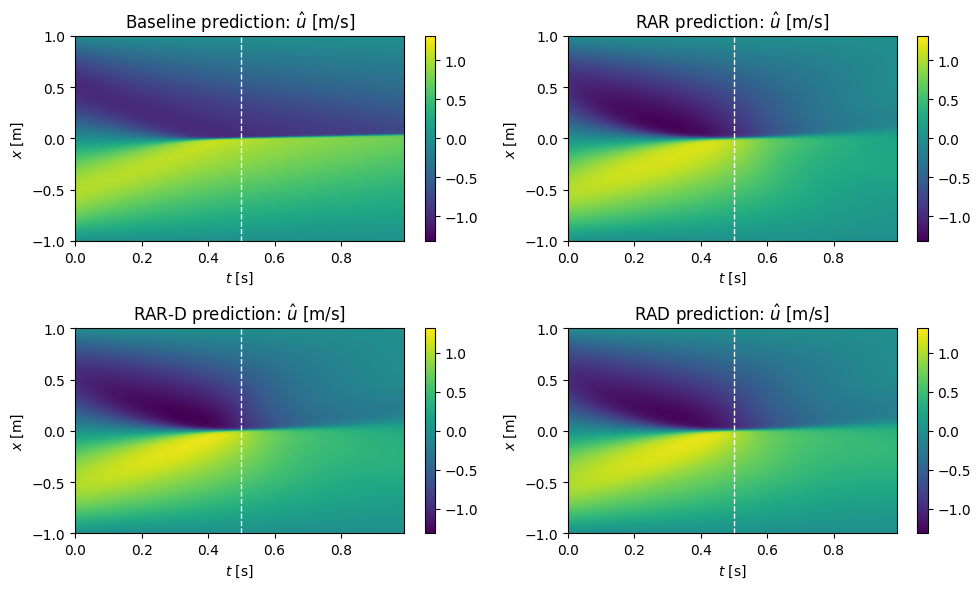

In [41]:
name_baseline = 'burger_baseline_sparse_noise01-sa005'
name_rar = 'burger_RAR_sparse_noise01-sa005'
name_rard = 'burger_RARD_sparse_noise01-sa005'
name_rad = 'burger_RAD_sparse_noise01-sa005'


plt.subplots(2, 2, figsize=(10, 6))

U = [get_predictions(name)[0] for name in [name_baseline, name_rar, name_rard, name_rad]]

# U.append(data.data_points_full[1].reshape(*data.original_shape).numpy())

v = max([np.max(abs(u)) for u in U])

for i, (U_pred, title) in enumerate(zip(U, ['Baseline', 'RAR', 'RAR-D', 'RAD'])):
    plt.subplot(2, 2, i+1)
    plt.imshow(U_pred, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='viridis', vmin=-v, vmax=v)
    plt.colorbar()
    for slice in data_slices:
        plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
    plt.title(title+r' prediction: $\hat{u}$ [m/s]')
    plt.xlabel(r'$t$ [s]'); plt.ylabel(r'$x$ [m]')

plt.tight_layout()
# plt.savefig('gfx/burger_upinn_refinement_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


[Info]: Initializing UPINN model
[Info]: Initializing UPINN model
[Info]: Initializing UPINN model
[Info]: Initializing UPINN model


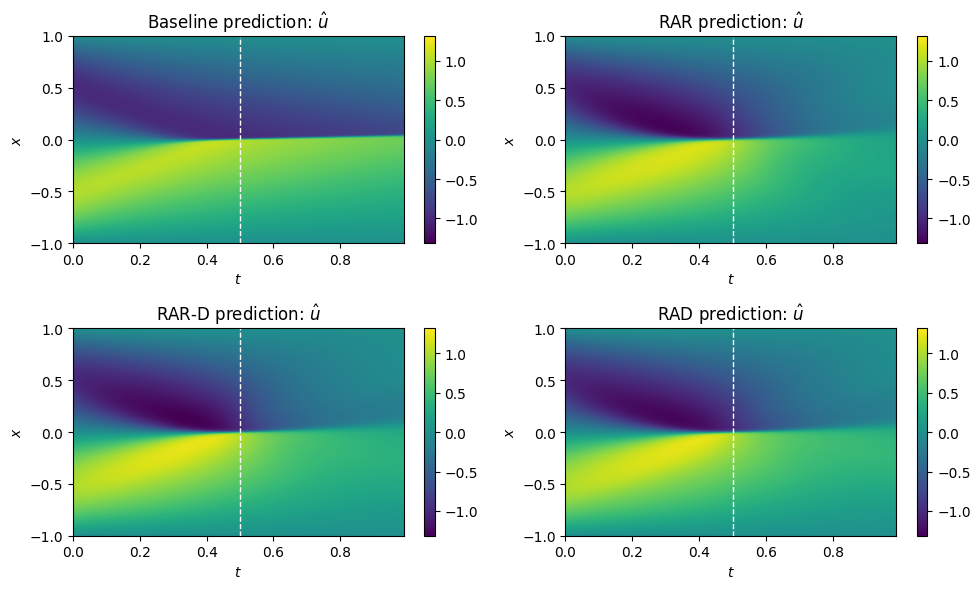

In [669]:
name_baseline_lbfgs = 'burger_baseline_sparse_noise01-sa005'
name_rar = 'burger_RAR_sparse_noise01-sa005'


plt.subplots(2, 2, figsize=(10, 6))

U = [get_predictions(name)[0] for name in [name_baseline, name_rar, name_rard, name_rad]]

# U.append(data.data_points_full[1].reshape(*data.original_shape).numpy())

v = max([np.max(abs(u)) for u in U])

for i, (U_pred, title) in enumerate(zip(U, ['Baseline', 'RAR', 'RAR-D', 'RAD'])):
    plt.subplot(2, 2, i+1)
    plt.imshow(U_pred, aspect='auto', extent=[t[0], t[-1], x[0], x[-1]], origin='lower', cmap='viridis', vmin=-v, vmax=v)
    plt.colorbar()
    for slice in data_slices:
        plt.plot([slice, slice], [-1, 1], linewidth=1, color='w', linestyle='--')
    plt.title(title+r' prediction: $\hat{u}$')
    plt.xlabel(r'$t$'); plt.ylabel(r'$x$')

plt.tight_layout()
plt.savefig('gfx/burger_upinn_refinement_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()